## Imports

In [1]:
from analasisAPI.subscriptionFinder import isDFweeklySchedule
from globals.column_names import DATE_COL
from analasisAPI.fileLoader import LoadFile
from analasisAPI.queries import filterDataFrameByRegex
from analasisAPI.queries import filterDataFrameByDate
from analasisAPI.queries import filterDataFrameByAmount
from analasisAPI.queries import queryBankDataFrame
from analasisAPI.plotUtilities import plotDataFrameTimeSeriesCol
import datetime

from classification.rule_based_classfier import classify_statement_from_rule_set
from classification.classification_report_utils import classification_pi_chart

import pandas as pd
import matplotlib.pyplot as plt


## Loading

In [6]:
# This should be the path to the file of your untouched BOA statement
# filepath = "/home/jvarela/Documents/financial/stmt.csv"
# filepath = "sample.csv"
# filepath = "sample_statements/BofA_debit.csv"
filepath = "sample_statements/Chase6491_Activity20220101_20221001_20221001.CSV"

from analasisAPI.fileLoader import isBoaDebitFile, isChaseFile

dataFrame = LoadFile(filepath)
print(dataFrame.head())

regexDF = filterDataFrameByRegex(dataFrame,"uber")
print(regexDF)

range1filter = filterDataFrameByDate(dataFrame,[datetime.datetime(2021,12,2),datetime.datetime(2022,12,22)])
range1filter.head()


        Date                   Description   Amount  Running Bal.  \
0 2022-09-29  TST* HARRY'S BAR &amp; GRILL   -32.49        -32.49   
1 2022-09-27      SQ *TOTTO RAMEN ASSEMBLY   -70.62       -103.11   
2 2022-09-25            AIRBNB  HMC5DRBKTF  -947.03      -1050.14   
3 2022-09-18       Payment Thank You - Web  1475.44        425.30   
4 2022-09-17     TST* FACES BREWING COMPAN   -46.99        378.31   

       Category  
0  Food & Drink  
1  Food & Drink  
2        Travel  
3           NaN  
4  Food & Drink  
Empty DataFrame
Columns: [Date, Description, Amount, Running Bal., Category]
Index: []


,Date,Description,Amount,Running Bal.,Category
0,2022-09-29,TST* HARRY'S BAR &amp; GRILL,-32.49,-32.49,Food & Drink
1,2022-09-27,SQ *TOTTO RAMEN ASSEMBLY,-70.62,-103.11,Food & Drink
2,2022-09-25,AIRBNB HMC5DRBKTF,-947.03,-1050.14,Travel
3,2022-09-18,Payment Thank You - Web,1475.44,425.30,NaN
4,2022-09-17,TST* FACES BREWING COMPAN,-46.99,378.31,Food & Drink


## Classification

In [10]:
max_expense = 10000.0 # max expense to analyze
expenses_only = dataFrame[dataFrame['Amount'] < 0] # get only expenses
small_expenses = filterDataFrameByAmount(expenses_only,[-max_expense,0.0]).copy()

classified_df = classify_statement_from_rule_set(small_expenses)

classified_df.drop(columns=["Running Bal."], inplace=True, errors="ignore")

classified_df = classified_df.drop_duplicates()

classified_df.to_csv("training_data.csv",index=False)
classified_df.head()

,Date,Description,Amount,Category,class
0,2022-09-29,TST* HARRY'S BAR &amp; GRILL,-32.49,Food & Drink,unknown
1,2022-09-27,SQ *TOTTO RAMEN ASSEMBLY,-70.62,Food & Drink,unknown
2,2022-09-25,AIRBNB HMC5DRBKTF,-947.03,Travel,unknown
4,2022-09-17,TST* FACES BREWING COMPAN,-46.99,Food & Drink,unknown
5,2022-09-15,TST* Cambridge Brewing Co,-40.01,Food & Drink,unknown


## Analysis

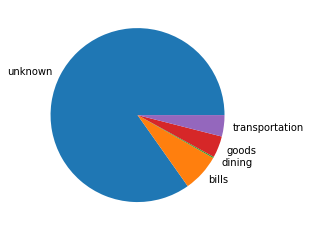

In [13]:
# Pi chart
classification_pi_chart(classified_df)


        Date                   Description  Amount      Category    class
0 2022-09-29  TST* HARRY'S BAR &amp; GRILL  -32.49  Food & Drink  unknown
1 2022-09-27      SQ *TOTTO RAMEN ASSEMBLY  -70.62  Food & Drink  unknown
4 2022-09-17     TST* FACES BREWING COMPAN  -46.99  Food & Drink  unknown
5 2022-09-15     TST* Cambridge Brewing Co  -40.01  Food & Drink  unknown
6 2022-09-13        BEST BUY MHT  00005967  -29.99      Shopping  unknown


<BarContainer object of 7 artists>

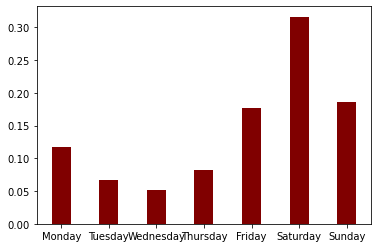

In [15]:
# Weekday binning
max_expense = 250.0 # max expense to analyze
expenses_only = classified_df[classified_df['Amount'] < 0] # get only expenses
small_expenses = filterDataFrameByAmount(expenses_only,[-max_expense,0.0])
print(small_expenses.head())

# Note zero is monday
week_df = small_expenses.groupby(small_expenses['Date'].dt.dayofweek)['Amount'].sum()
day_of_week_names = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
days = []
spent_on_day = []
for day in week_df.keys():
    days.append(day_of_week_names[day])
    spent_on_day.append(-week_df[day])
total_spent = sum(spent_on_day)
spent_on_day = [val/total_spent for val in spent_on_day]
plt.bar(days, spent_on_day, color ='maroon',
        width = 0.4)
# I think I'm missing the weekend expenses as I always pay with my credit card on weekends?